# Projekt Eksploracji Danych Youtube Trending

## Import bibliotek

In [546]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns
import multiprocessing as mp
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # To plot dates on histograms' axis
import itertools
from collections import Counter
from wordcloud import WordCloud
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re

In [382]:
from sklearn.externals.joblib import Memory
memory = Memory(location='./joblib', verbose=0)

In [383]:
style.use('seaborn-poster') # sets the size of the charts
style.use('ggplot')

## Wczytanie danych

In [475]:
data_gb = pd.read_csv("./youtube_data/GB_videos_5p.csv", sep=";")
data_us = pd.read_csv("./youtube_data/US_videos_5p.csv", sep=";")
data = pd.concat([data_gb, data_us])
data.reset_index(drop=True, inplace=True)

In [476]:
data.shape

(79816, 16)

≈ÅƒÖcznie, dane z obu plik√≥w zawierajƒÖ 79816 wierszy, z kt√≥rych ka≈ºdy opisany jest za pomocƒÖ nastƒôpujƒÖcych atrybut√≥w:

In [477]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79816 entries, 0 to 79815
Data columns (total 16 columns):
video_id                  79816 non-null object
trending_date             79816 non-null object
title                     79816 non-null object
channel_title             79816 non-null object
category_id               3930 non-null float64
publish_time              79816 non-null object
tags                      79816 non-null object
views                     79816 non-null int64
likes                     79816 non-null int64
dislikes                  79816 non-null int64
comment_count             79816 non-null int64
thumbnail_link            79816 non-null object
comments_disabled         79816 non-null bool
ratings_disabled          79816 non-null bool
video_error_or_removed    79816 non-null bool
description               78634 non-null object
dtypes: bool(3), float64(1), int64(4), object(8)
memory usage: 8.1+ MB


Przyk≈Çadowe dane:

In [478]:
data.head()

video_id trending_date  \
0  Jw1Y-zhQURU      17.14.11   
1  3s1rvMFUweQ      17.14.11   
2  n1WpP7iowLc      17.14.11   
3  PUTEiSjKwJU      17.14.11   
4  rHwDegptbI4      17.14.11   

                                               title  \
0      John Lewis Christmas Ad 2017 - #MozTheMonster   
1          Taylor Swift: ‚Ä¶Ready for It? (Live) - SNL   
2         Eminem - Walk On Water (Audio) ft. Beyonc√©   
3  Goals from Salford City vs Class of 92 and Fri...   
4  Dashcam captures truck's near miss with child ...   

                channel_title  category_id              publish_time  \
0                  John Lewis          NaN  2017-11-10T07:38:29.000Z   
1         Saturday Night Live          NaN  2017-11-12T06:24:44.000Z   
2                  EminemVEVO          NaN  2017-11-10T17:00:03.000Z   
3  Salford City Football Club          NaN  2017-11-13T02:30:38.000Z   
4            Cute Girl Videos          NaN  2017-11-13T01:45:13.000Z   

                                                tags     views   likes  \
0  christmas|"john lewis christmas"|"john lewis"|...   7224515   55681   
1  SNL|"Saturday Night Live"|"SNL Season 43"|"Epi...   1053632   25561   
2  Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/In...  17158579  787420   
3  Salford City FC|"Salford City"|"Salford"|"Clas...     27833     193   
4                                             [none]      9815      30   

   dislikes  comment_count                                  thumbnail_link  \
0     10247           9479  https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg   
1      2294           2757  https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg   
2     43420         125882  https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg   
3        12             37  https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg   
4         2             30  https://i.ytimg.com/vi/rHwDegptbI4/default.jpg   

   comments_disabled  ratings_disabled  video_error_or_removed  \
0              False             False                   False   
1              False             False                   False   
2              False             False                   False   
3              False             False                   False   
4              False             False                   False   

                                        description   
0  Click here to continue the story and make your...  
1  Musical guest Taylor Swift performs ‚Ä¶Ready for...  
2  Eminem's new track Walk on Water ft. Beyonc√© i...  
3  Salford drew 4-4 against the Class of 92 and F...  
4  Dashcam captures truck's near miss with child ...

## Analiza atrybut√≥w

### video_id

In [479]:
data.video_id.value_counts()

#NAZWA?        725
8h--kFui1JA     65
vjSohj-Iclc     62
VYOjWnS4cMY     61
l884wKofd54     60
              ... 
J-NEOU-Ujeg      1
vNfkwsj8RpQ      1
wOFuVNiAJQQ      1
y00fPzC-xiA      1
fiusxyygqGk      1
Name: video_id, Length: 8510, dtype: int64

W≈õr√≥d danych 725 razy wystƒôpuje `#NAZWA?`. Jest to b≈ÇƒÖd danych, kt√≥ry nale≈ºy albo naprawiƒá, albo usunƒÖƒá wiersze z wystƒôpujƒÖcym b≈Çƒôdem. Po przyjrzeniu siƒô danym, mo≈ºna zauwa≈ºyƒá, ≈ºe dla ka≈ºdego innego wiersza, warto≈õƒá pola `video_id` wystƒôpuje r√≥wnie≈º w atrybucie `thumbnail_link` jako czƒô≈õƒá linku do miniaturki filmu. Aby nie traciƒá danych, pos≈Çu≈ºono siƒô tym atrybutem, wycinajƒÖc ze ≈õcie≈ºki odpowiedni cz≈Çon i zastƒÖpiono nim b≈Çƒôdne pole `video_id`.

In [480]:
def get_id(v_id, link):
    if v_id == "#NAZWA?":
        tokens = link.split('/')
        return tokens[-2]
    else: return v_id

In [481]:
data['video_id'] = data.apply(lambda row : get_id(row.video_id, row.thumbnail_link), axis = 1) 

In [482]:
data.to_csv("./youtube_data/videos_5p.csv", sep=";") # zapisujemy poprawione dane w celu p√≥≈∫niejszego wykorzystania do komunikacji poprzez YT API

In [483]:
data.video_id.value_counts()

8h--kFui1JA    65
vjSohj-Iclc    62
VYOjWnS4cMY    61
l884wKofd54    60
zxwfDlhJIpw    59
               ..
LnA4DGoihak     1
8DR0RhpKp2k     1
oipLbJoV9pM     1
kATuE1S5qk0     1
sQ0HnQq9IvE     1
Name: video_id, Length: 8606, dtype: int64

Atrybut `video_id` jest identyfikatorem filmu w serwisie YouTube. W≈õr√≥d wszystkich wpis√≥w wystƒôpuje tylko 8606 unikalnych identyfikator√≥w, co oznacza, ≈ºe wiƒôkszo≈õƒá film√≥w utrzymywa≈Ça siƒô na li≈õcie Trending przez d≈Çu≈ºszy czas.

### trending_date

In [484]:
data.trending_date = pd.to_datetime(data.trending_date, format="%y.%d.%m")

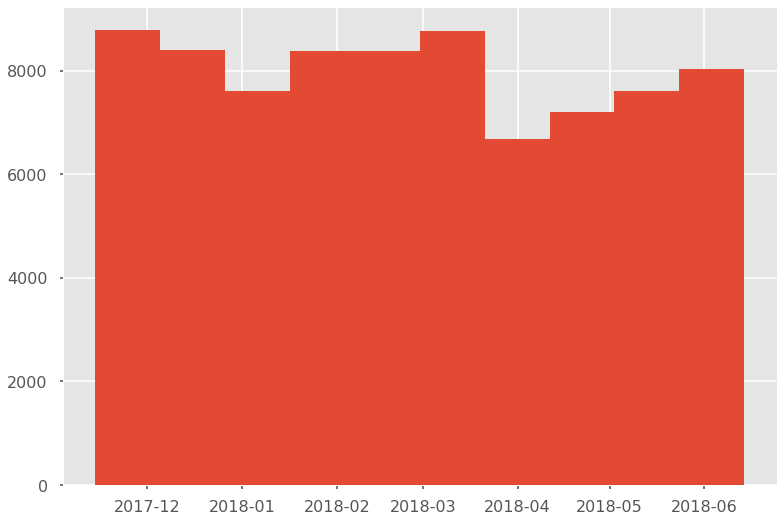

In [485]:
data.trending_date.hist()

Dane pochodzƒÖ z okresu od listopada 2017 roku do czerwca 2018 roku i sƒÖ roz≈Ço≈ºone r√≥wnomiernie.

### title

Sam Smith - Pray (Official Video) ft. Logic                                            65
Getting some air, Atlas?                                                               62
Childish Gambino - This Is America (Official Video)                                    61
Enrique Iglesias - MOVE TO MIAMI (Official Video) ft. Pitbull                          60
Kelly Clarkson - Meaning of Life [Official Video]                                      59
                                                                                       ..
Trump pardons Thanksgiving turkey                                                       1
Milck - Quiet [Official Video]                                                          1
Charlamagne: Trump Is Revealing A Lot About Us                                          1
BTS EXCLUSIVE Off-Air Performances                                                      1
Do you believe Carmelo Anthony? Stephen A. Smith says 'hell no' | First Take | ESPN     1
Name: titl

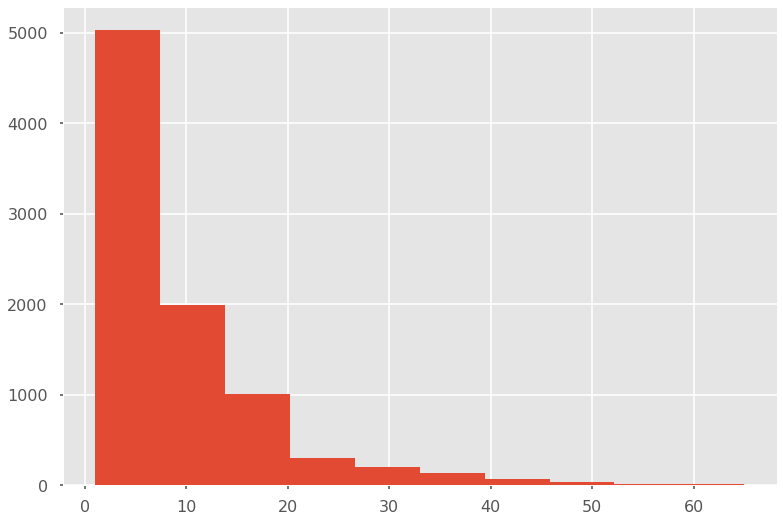

In [486]:
data.title.value_counts().hist()
data.title.value_counts()

Wiƒôkszo≈õƒá film√≥w by≈Ça na li≈õcie Trending raz lub kilka razy, natomiast zdarza≈Çy siƒô r√≥wnie≈º takie, kt√≥re utrzymywa≈Çy siƒô przez d≈Çugi okres czasu.

### Channel title

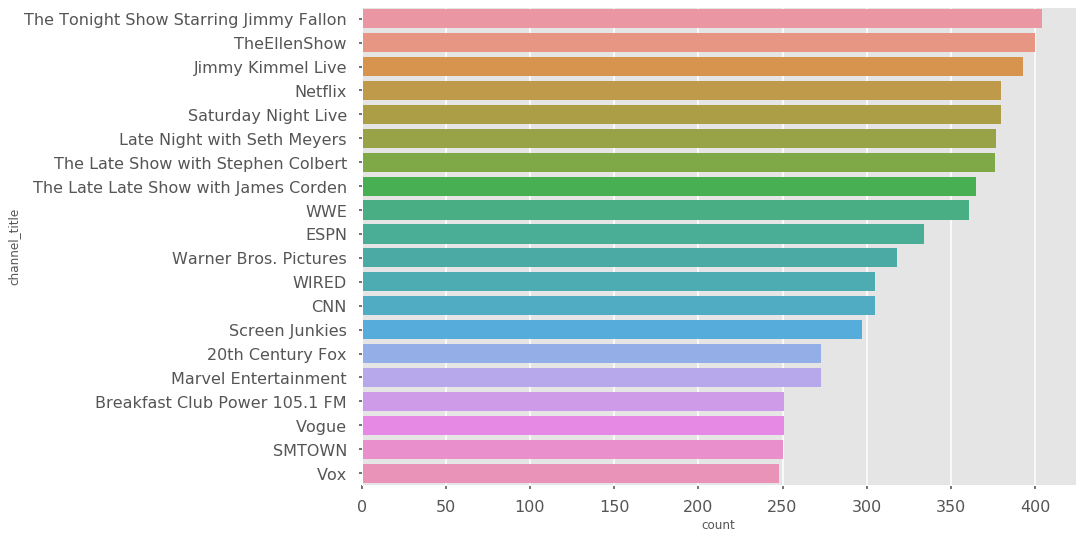

In [487]:
sns.countplot(y='channel_title', data=data, order=data.channel_title.value_counts().iloc[:20].index, orient="h")

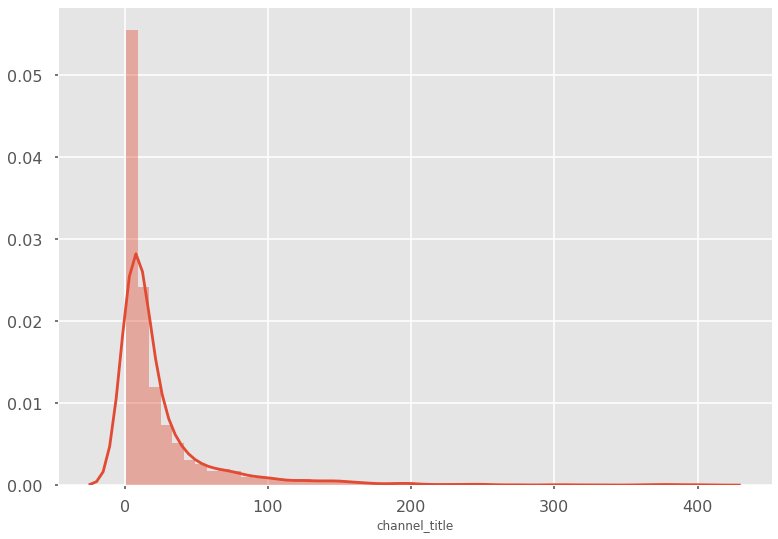

In [488]:
sns.distplot(data.channel_title.value_counts())

Niekt√≥re kana≈Çy wystƒôpujƒÖ w danych znacznie czƒô≈õciej ni≈º inne. Jest to spowodowane tym, ≈ºe sƒÖ to kana≈Çy znane globalnie, majƒÖce du≈ºƒÖ ilo≈õƒá subskrybent√≥w. ≈Åatwiej im trafiƒá do wiƒôkszej publiczno≈õci i zdobyƒá wysokƒÖ popularno≈õƒá film√≥w.

### category_id

In [489]:
data.category_id.value_counts(dropna=False)
data.category_id.isnull().sum()*100/len(data)

95.07617520296682

Nazwa kategorii jest pusta dla 95% przypadk√≥w. Jak wiemy z opisu ƒáwiczenia, uzupe≈Çnienie jej bƒôdzie jednym z zada≈Ñ, dlatego na tym etapie pozostaje niezmieniona.

### publish_time

In [490]:
data.publish_time.head()
data.publish_time = pd.to_datetime(data.publish_time)

### Rok publikacji

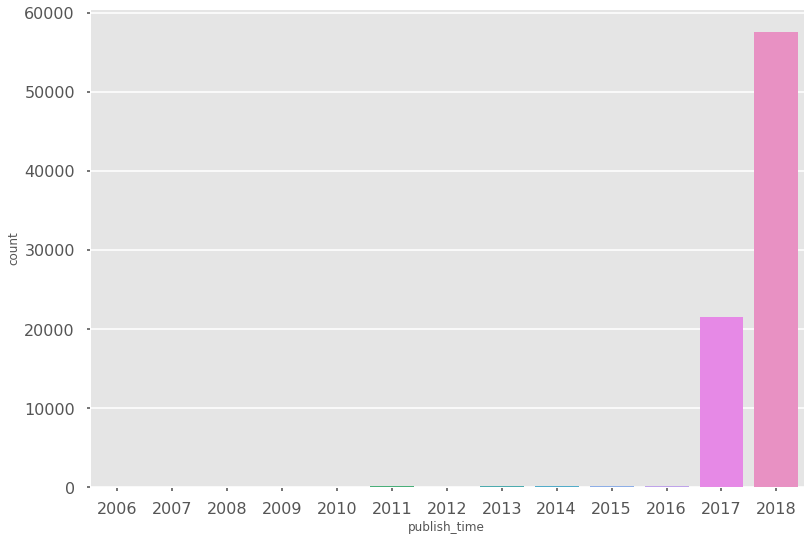

In [491]:
sns.countplot(data.publish_time.dt.year)

Jak widaƒá na wykresie przewa≈ºajƒÖca wiƒôkszosƒá film√≥w opublikowana zosta≈Ça w roku 2018.  
Za istotny mo≈ºna uznaƒá jeszcze rok 2017. Pozosta≈Çe ilo≈õci sƒÖ pomijalne

#### MiesiƒÖc publikacji

Text(0.5, 0, 'Publish month')

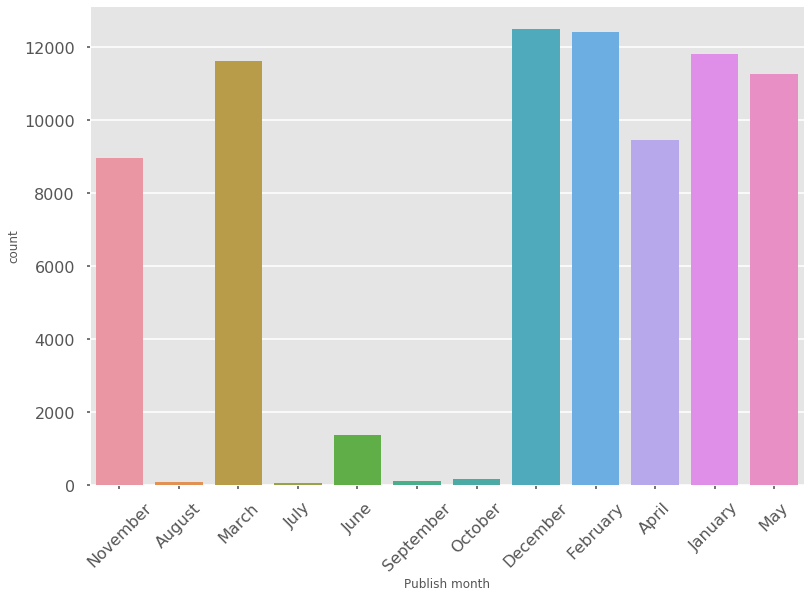

In [492]:
data["publish_month"] = data.publish_time.dt.month
sns.countplot(data.publish_time.dt.month_name())
plt.xticks(rotation=45)
plt.xlabel('Publish month')

### Czas publikacji

#### Godzina

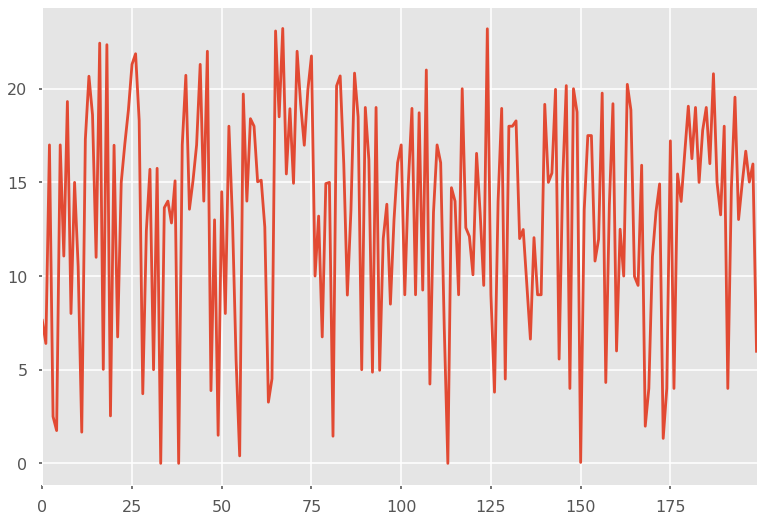

In [493]:
data["publish_hour"] = data.publish_time.dt.hour + data.publish_time.dt.minute/60
data.publish_hour[0:200].plot()

Text(0.5, 0, 'Publication hour')

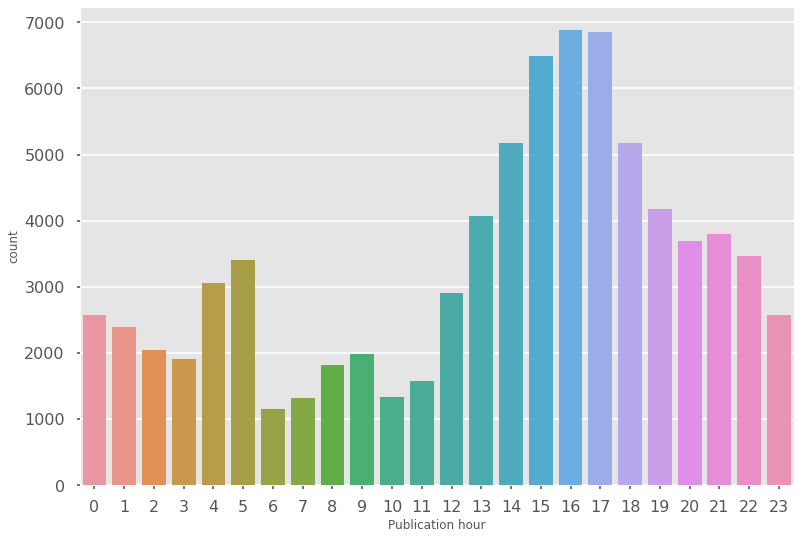

In [494]:
sns.countplot(data.publish_time.dt.hour)
plt.xlabel("Publication hour")

Na wykresie widaƒá, i≈º szczyt publikacji przypada na godzinƒô 16 i 17.  
Widoczny jest te≈º pik w okolicy godziny 5

#### Dzie≈Ñ

In [495]:
data["publish_day"] = data.publish_time.dt.weekday

In [496]:
days = data.publish_time.dt.day_name().unique()
print(days[[2,6,5,4,0,3,1]])

['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']


Text(0.5, 0, 'Publish day')

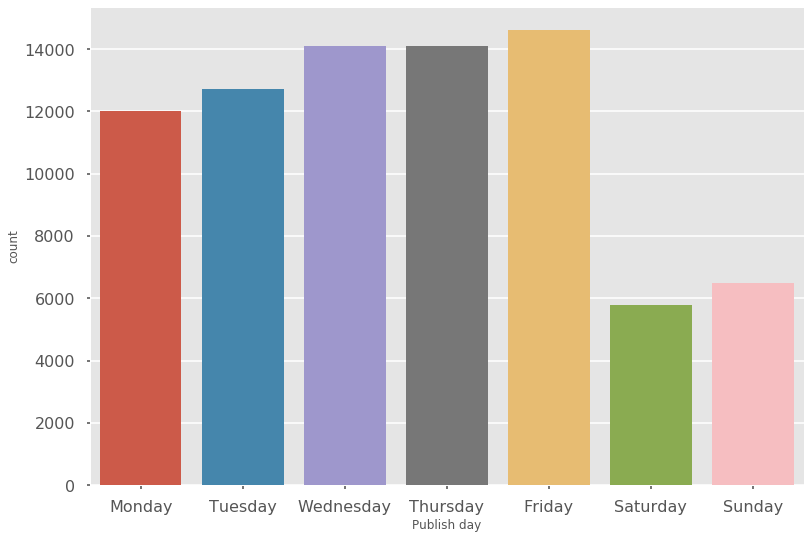

In [497]:
sns.countplot(data.publish_time.dt.day_name(), order=days[[2,6,5,4,0,3,1]])
plt.xlabel("Publish day")

Wiƒôkszo≈õƒá film√≥w publikowana jest w ciƒÖgu tygodnia, w trakcie weekendu spada ilo≈õƒá publikacji

### Tags

In [498]:
data.tags.head()

0    christmas|"john lewis christmas"|"john lewis"|...
1    SNL|"Saturday Night Live"|"SNL Season 43"|"Epi...
2    Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/In...
3    Salford City FC|"Salford City"|"Salford"|"Clas...
4                                               [none]
Name: tags, dtype: object

In [499]:
data.tags.values[0]

'christmas|"john lewis christmas"|"john lewis"|"christmas ad"|"mozthemonster"|"christmas 2017"|"christmas ad 2017"|"john lewis christmas advert"|"moz"'

In [500]:
data.tags.values[0].replace('"',"").split('|')

['christmas',
 'john lewis christmas',
 'john lewis',
 'christmas ad',
 'mozthemonster',
 'christmas 2017',
 'christmas ad 2017',
 'john lewis christmas advert',
 'moz']

In [501]:
def prepare_tags(tags):
    return tags.lower().replace('"', '').split('|') if tags != '[none]' else None

data['tags_split'] = data.tags.apply(prepare_tags)

Text(0.5, 1.0, 'Most used tags')

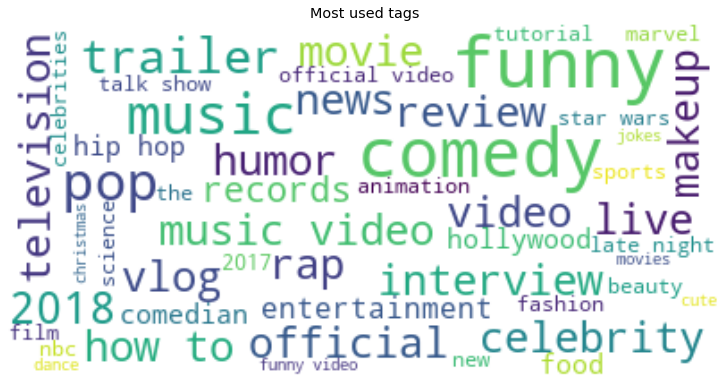

In [502]:
all_tags = [tags for tags in data.tags_split if tags != None]
all_tags = list(itertools.chain.from_iterable(all_tags))
tags100 = {a: b for a, b in Counter(all_tags).most_common(100)}
wordcloud = WordCloud(background_color='white',
                      max_words=50, 
                      max_font_size=40,
                      random_state=42).generate_from_frequencies(tags100)
plt.imshow(wordcloud, interpolation="bilinear")
plt.grid(b=None)
plt.axis("off")
plt.title("Most used tags")

Na powy≈ºszej grafice przedstawiono najczƒô≈õciej wystƒôpujƒÖce tagi. Wiƒôkszo≈õƒá z nich zwiƒÖzana jest z rozrywkƒÖ i spƒôdzaniem czasu wolnego.

In [503]:
# Get top1000 tags for each month

tags_monthly = {}
all_top_monthly = {}

for i in range(1, 13):
    all_tags = [tags for tags in data.loc[data.publish_month==i, 'tags_split'] if tags != None]
    all_tags = list(itertools.chain.from_iterable(all_tags))
    tags = {a: b for a, b in Counter(all_tags).most_common(1000)}
    tags_monthly[i] = tags
    all_top_monthly[i] = list(tags.keys())

# Get unique ones from recieved tops
unique_monthly = [entry for entry, num in Counter(itertools.chain.from_iterable(all_top_monthly.values())).most_common() if num==1]

# Remove non-unique ones from each month's top1000
for month in tags_monthly:
    to_delete = []
    for tag in tags_monthly[month]:
        if not(tag in unique_monthly):
            to_delete.append(tag)
    for tag in to_delete:
        del tags_monthly[month][tag]
        
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate_from_frequencies(tup)
    return wordcloud

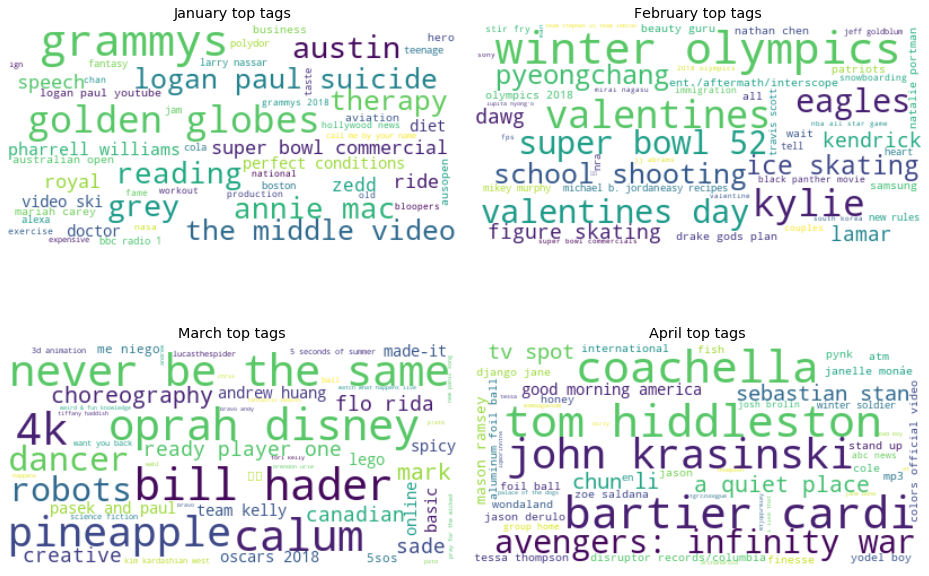

In [504]:
fig, axs = plt.subplots(2,2, constrained_layout=True)

axs[0,0].imshow(generate_wordcloud(tags_monthly[1]), interpolation="bilinear")
axs[0,0].title.set_text("January top tags")

axs[0,1].imshow(generate_wordcloud(tags_monthly[2]), interpolation="bilinear")
axs[0,1].title.set_text("February top tags")

axs[1,0].imshow(generate_wordcloud(tags_monthly[3]), interpolation="bilinear")
axs[1,0].title.set_text("March top tags")

axs[1,1].imshow(generate_wordcloud(tags_monthly[4]), interpolation="bilinear")
axs[1,1].title.set_text("April top tags")

for ax in fig.axes:
    ax.grid(b=None)
    ax.axis("off")

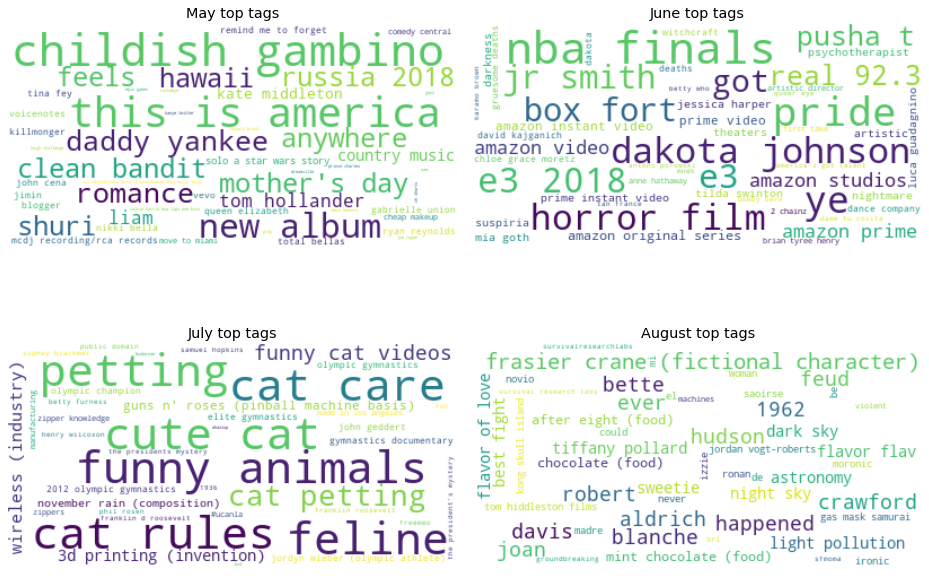

In [505]:
fig, axs = plt.subplots(2,2, constrained_layout=True)

axs[0,0].imshow(generate_wordcloud(tags_monthly[5]), interpolation="bilinear")
axs[0,0].title.set_text("May top tags")

axs[0,1].imshow(generate_wordcloud(tags_monthly[6]), interpolation="bilinear")
axs[0,1].title.set_text("June top tags")

axs[1,0].imshow(generate_wordcloud(tags_monthly[7]), interpolation="bilinear")
axs[1,0].title.set_text("July top tags")

axs[1,1].imshow(generate_wordcloud(tags_monthly[8]), interpolation="bilinear")
axs[1,1].title.set_text("August top tags")

for ax in fig.axes:
    ax.grid(b=None)
    ax.axis("off")

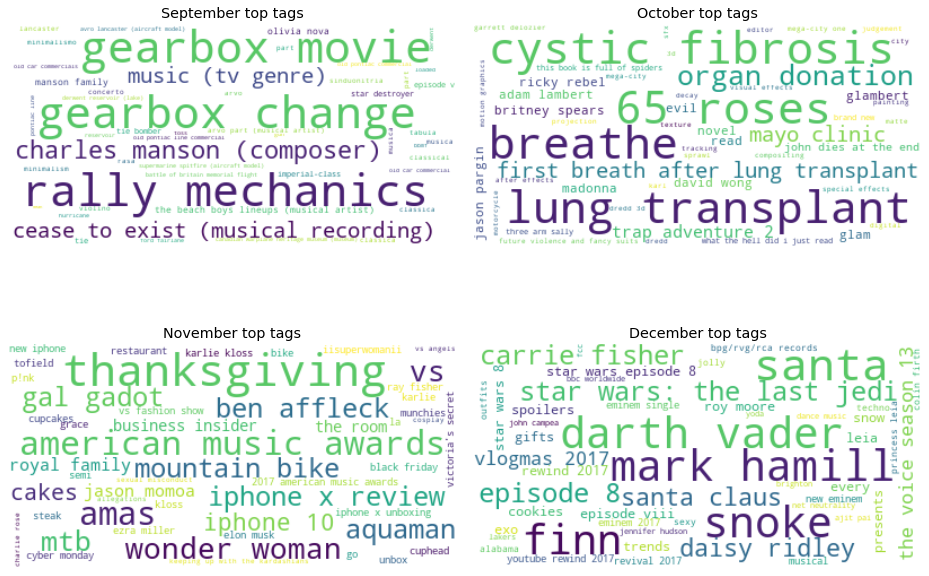

In [506]:
fig, axs = plt.subplots(2,2, constrained_layout=True)

axs[0,0].imshow(generate_wordcloud(tags_monthly[9]), interpolation="bilinear")
axs[0,0].title.set_text("September top tags")

axs[0,1].imshow(generate_wordcloud(tags_monthly[10]), interpolation="bilinear")
axs[0,1].title.set_text("October top tags")

axs[1,0].imshow(generate_wordcloud(tags_monthly[11]), interpolation="bilinear")
axs[1,0].title.set_text("November top tags")

axs[1,1].imshow(generate_wordcloud(tags_monthly[12]), interpolation="bilinear")
axs[1,1].title.set_text("December top tags")

for ax in fig.axes:
    ax.grid(b=None)
    ax.axis("off")

### Views

In [507]:
data.views.describe()

count    7.981600e+04
mean     4.089589e+06
std      1.439442e+07
min      5.490000e+02
25%      2.462062e+05
50%      7.952275e+05
75%      2.533302e+06
max      4.245389e+08
Name: views, dtype: float64

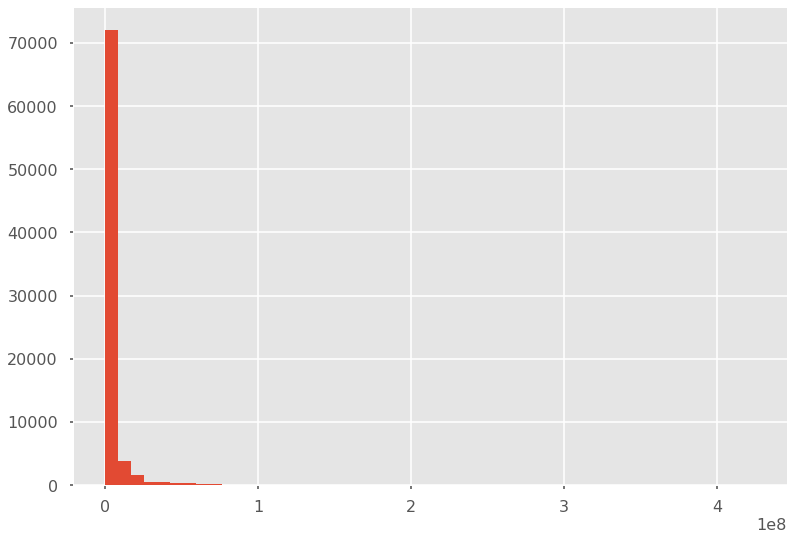

In [508]:
data.views.hist(bins=50)

### Likes

In [509]:
data.likes.describe()

count    7.981600e+04
mean     1.036131e+05
std      2.958002e+05
min      0.000000e+00
25%      5.637750e+03
50%      2.090300e+04
75%      7.816350e+04
max      5.613827e+06
Name: likes, dtype: float64

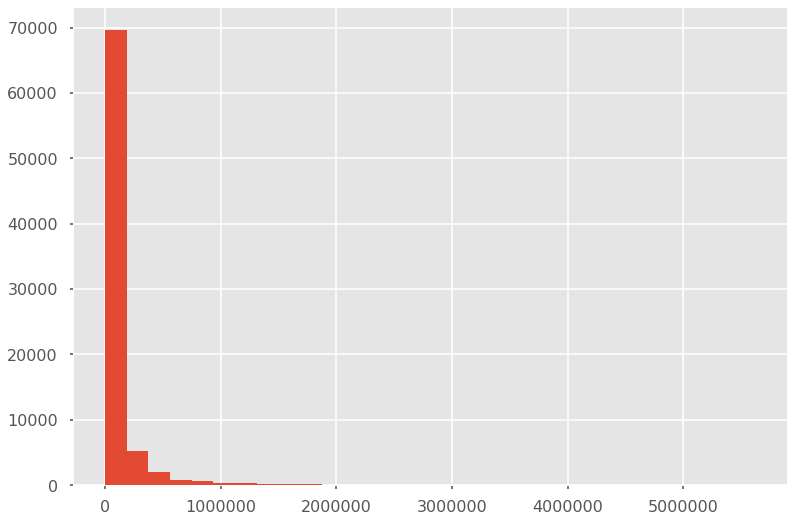

In [510]:
data.likes.hist(bins=30)

### Dislikes

In [511]:
data.dislikes.describe()

count    7.981600e+04
mean     5.612412e+03
std      4.125681e+04
min      0.000000e+00
25%      2.010000e+02
50%      7.110000e+02
75%      2.526000e+03
max      1.944971e+06
Name: dislikes, dtype: float64

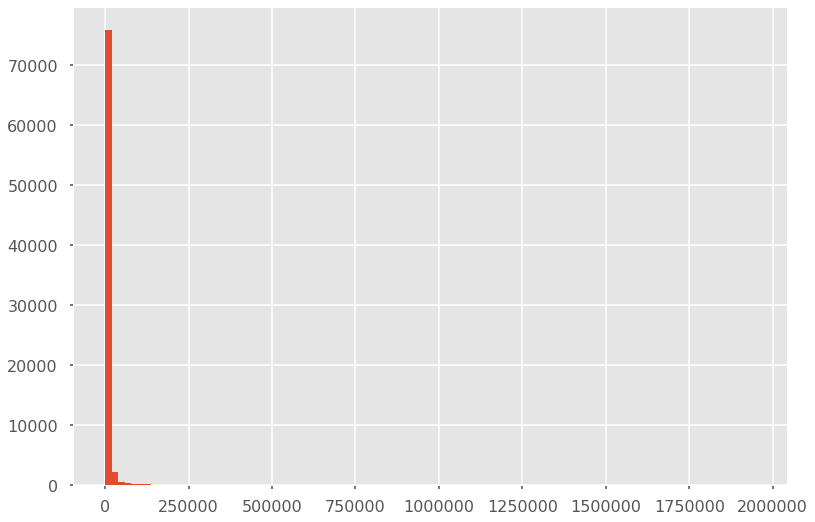

In [512]:
data.dislikes.hist(bins=100)

### Comment count

In [513]:
data.comment_count.describe()

count    7.981600e+04
mean     1.070894e+04
std      4.444967e+04
min      0.000000e+00
25%      6.420000e+02
50%      2.099000e+03
75%      7.215000e+03
max      1.626501e+06
Name: comment_count, dtype: float64

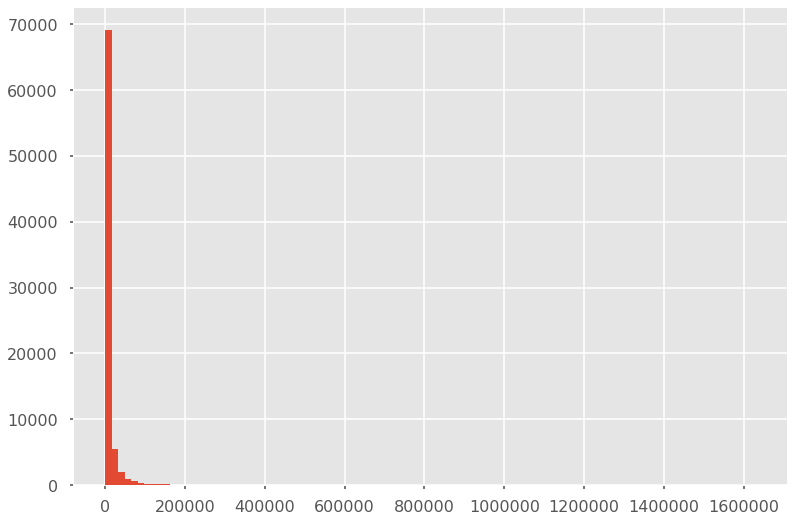

In [514]:
data.comment_count.hist(bins=100)

Liczba wy≈õwietle≈Ñ, poozytywnych i negatywnych reakcji a tak≈ºe liczba komentarzy majƒÖ rozk≈Çad prawosko≈õny - w danych wystƒôpuje ma≈Ça liczba film√≥w o rekordowej oglƒÖdalno≈õci, wzbudzajƒÖcych bardzo du≈ºo pozytywnych i negatywnych reakcji i komentarzy. Wiƒôkszo≈õƒá film√≥w jest do siebie zbli≈ºona z globalnego punktu widzenia.

### Thumbnail_link

In [515]:
data.thumbnail_link.head()

0    https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg
1    https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg
2    https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg
3    https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg
4    https://i.ytimg.com/vi/rHwDegptbI4/default.jpg
Name: thumbnail_link, dtype: object

Wszystkie linki majƒÖ podobnƒÖ strukturƒô: r√≥≈ºniƒÖ siƒô jedynie cz≈Çonem stanowiƒÖcym identyfikator filmu.

### comments_disabled

In [516]:
data.comments_disabled.value_counts()

False    78501
True      1315
Name: comments_disabled, dtype: int64

Filmy z wy≈ÇƒÖczonƒÖ mo≈ºliwo≈õciƒÖ komentowania stanowiƒÖ jedynie 1,65% ca≈Çego zbioru danych. W dalszej czƒô≈õci projektu ciekawym zagadnieniem mo≈ºe okazaƒá siƒô analiza tych film√≥w - jakie by≈Çy prawdopodobne powody wy≈ÇƒÖczenia komentarzy oraz jednoczesna wysoka popularno≈õƒá - mo≈ºe by≈Çy to komunikaty rzƒÖdowe, kontrowersyjne tre≈õci, a mo≈ºe jeszcze inne? 

### Rating disabled

In [517]:
data.ratings_disabled.value_counts()

False    79376
True       440
Name: ratings_disabled, dtype: int64

Filmy z wy≈ÇƒÖczonƒÖ mo≈ºliwo≈õciƒÖ oceniania stanowiƒÖ 0,55% ca≈Çego zbioru danych. Jak wy≈ºej, analiza powod√≥w takiej decyzji mo≈ºe byƒá interesujƒÖcym zagadnieniem.

### video_error_or_removed 

In [518]:
data.video_error_or_removed.value_counts()

False    79724
True        92
Name: video_error_or_removed, dtype: int64

Filmy usuniƒôte lub powodujƒÖce b≈Çƒôdy stanowiƒÖ 0,12% ca≈Çego zbioru danych. Byƒá mo≈ºe niekt√≥re z nich zdoby≈Çy popularno≈õƒá ze wzglƒôdu wysokiej kontrowersyjno≈õci i zosta≈Çy z tego samego powodu usuniƒôte? Mo≈ºe ≈Çama≈Çy prawa autorskie? Przyjrzymy siƒô im w kolejnym etapie analizy.

**Can we remove those ones? --- jak bƒôdzie nam siƒô chcia≈Ço to ja bym z ciekwo≈õci poszuka≈Ça co to sƒÖ za filmy i dlaczego mog≈Çy zostaƒá usuniƒôte ---> Byƒá mo≈ºe wnioskiem z ca≈Çej analizy bƒôdzie "Wrzuƒá na Jutuba film, kt√≥ry bƒôdzie obra≈ºa≈Ç wszystkich, byc mo≈ºe uda ci siƒô byƒá w trending zanim kto≈õ w YT siƒô ogarnie" XD Zrobi≈Çabym sprawdzenie korelacji z liczbƒÖ dislikes.**

### description

In [519]:
data.columns = data.columns.str.replace('description ', 'description')

In [520]:
data.description.values[0]

"Click here to continue the story and make your own monster:\\nhttp://bit.ly/2mboXgj\\n\\nJoe befriends a noisy Monster under his bed but the two have so much fun together that he can't get to sleep, leaving him tired by day. For Christmas Joe receives a gift to help him finally get a good night‚Äôs sleep.\\n\\nShop the ad\\nhttp://bit.ly/2hg04Lc\\n\\nThe music is Golden Slumbers performed by elbow, the original song was by The Beatles. \\nFind the track:\\nhttps://Elbow.lnk.to/GoldenSlumbersXS\\n\\nSubscribe to this channel for regular video updates\\nhttp://bit.ly/2eU8MvW\\n\\nIf you want to hear more from John Lewis:\\n\\nLike John Lewis on Facebook\\nhttp://www.facebook.com/johnlewisretail\\n\\nFollow John Lewis on Twitter\\nhttp://twitter.com/johnlewisretail\\n\\nFollow John Lewis on Instagram\\nhttp://instagram.com/johnlewisretail"

## Wytworzenie atrybut√≥w do predykcji

Dostƒôpne atrybuty sƒÖ mniej lub bardziej informatywne dla postawionego problemu. Na przyk≈Çad mo≈ºna zastanowiƒá siƒô, czy liczba pozytywnych reakcji sprzyja wy≈ºszej oglƒÖdalno≈õci, jednak nie jest to czynnik, kt√≥ry autor filmu ma pod kontrolƒÖ. Niekt√≥re z artybut√≥w mo≈ºna poddaƒá dodatkowym operacjom majƒÖcym na celu ekstrakcjƒô cech, kt√≥re bƒôdƒÖ przydatne w procesie odkrywania wiedzy. Do takich atrybut√≥w nale≈ºƒÖ na pewno: `title`, `tags`, `description`. Atrybuty takie jak: `comments_disabled`, `ratings_disabled`, `comment_count`, `video_error_or_removed`, `dislikes`, `publish_time` mogƒÖ czƒô≈õciowo wchodziƒá w korelacje z innymi atrybutami (np. mo≈ºna spodziewaƒá siƒô, ≈ºe w okresie ≈õwiƒÖtecznym w tagach bƒôdzie przewa≈ºa≈Ço s≈Çowo "christmas", flaga `video_error_or_removed` mo≈ºe byƒá w zale≈ºno≈õci z liczbƒÖ negatywnych reakcji itp.). Atrybutami, kt√≥rych nie bƒôdziemy analizowaƒá w tej czƒô≈õci sƒÖ: `video_id` - ze wzglƒôdu na to, ≈ºe jest to unikalny identyfikator filmu, `views` - niemo≈ºno≈õƒá bezpo≈õredniego wp≈Çywu, `category_id` - brak danych z wiadomych przyczyn.

Odno≈õnie dalszych dzia≈Ça≈Ñ to bym to widzia≈Ça tak:
- Dla ka≈ºdego z {title, tags, description}:
   
    - tokenizacja
    - usuniƒôcie stopwords
    - (lematyzacja/stemming)
    - wytworzenie reprezentacji word2vec, tfidf, embeddings (nwm czy wszystkie, mo≈ºe tylko niekt√≥re/jeden z nich albo inne)
    - ? mo≈ºe wytworzenie jakiego≈õ/jakich≈õ binarnych atrybut√≥w m√≥wiƒÖcych o tym, czy posiada s≈Çowa, kt√≥re w danym czasie by≈Çy najbardziej "na czasie" - tzn. na przyk≈Çad w lipcu mamy, ≈ºe najczƒô≈õciej pojawiajƒÖ siƒô "science, independence, cat" i atrybut mia≈Çby True, je≈õli dla tego filmu te≈º wystƒôpujƒô jedno z nich np. "science"  **Bardzo podoba mi siƒô pomys≈Ç**
    - procentowa zawarto≈õƒá capital letters
    - obecno≈õƒá znak√≥w typu emotikony, wykrzykniki, znaki zapytania itp.
    - d≈Çugo≈õƒá ca≈Çego tekstu
    
    
- sprawdzenie prawdopodobnych korelacji, o kt√≥rych pisa≈Çam wy≈ºej
- R√≥wnolegle dobrze by by≈Ço ogarnƒÖƒá YouTube API i zaczƒÖƒá ≈õciƒÖgaƒá dane potrzebne do punktu 5

Propozycje atrybut√≥w tekstowych:,
 * Czy wystƒôpuje link / ilo≈õƒá link√≥w,
 * Czy opis zawiera tagi / ilo≈õƒá tag√≥w zawartych w opisie,
 * Ilo≈õƒá tag√≥w,    
 * Czy zawarty jest link do FB / Instagrama / SnapChata / Twittera... (lub czy w og√≥le do jakich≈õ medi√≥w spo≈Çeczno≈õciowych),
 * D≈Çugo≈õƒá opisu,
 * NLP - Proponujƒô u≈ºyƒá Tf-Idf by mieƒá punkt wyj≈õcia i jednej DLowej metody - ELMO lub BERT (ja mam do≈õwiadczenie z ELMO),
 
Atrybuty pozatekstowe:
  * Czy opublikowane w weekend,
  * Godzina publikacji (kodowanie atrybutu - ciekawy temat),
  * Czy jest muzykƒÖ? (pytanie jak sprawdziƒá?), **pewnie mo≈ºna po kategorii, kt√≥rej na razie nie mamy**
  * Czy komentarze wy≈ÇƒÖczone,
  * Czy rating wy≈ÇƒÖczony

In [521]:
def length(wordlist):
    if wordlist is None: return 0
    else: return len(wordlist)

def onlyalpha(string):
    return word_tokenize(''.join([char for char in string if char.isalpha() or char.isspace()]))

def count_capitals(alphalist):
    string = ''.join(alphalist)
    if len(string) == 0:
        return 0
    else: return len([char for char in string if char.isupper()])/ len(string)
    
def tokenize(column):
    if column is None:
        return []
    else:
        string = str(column)
        return word_tokenize(string)

def count_words(linklist, word):
    return ''.join(linklist).count(word)

### Atrybuty wytworzone z tytu≈Çu

Nowe atrybuty:
 * `title_num_words` - z ilu s≈Ç√≥w sk≈Çada siƒô tytu≈Ç (wykluczamy liczby) 
 * `title_capital` - procentowa zawarto≈õƒá wielkich liter
 * `title_exc_count` - liczba wykrzyknik√≥w
 * `title_que_count` - liczba znak√≥w zapytania

In [522]:
data['title_split'] = data.title.apply(word_tokenize)
data['title_alpha'] = data.title.apply(onlyalpha)
data['title_num_words'] = data.title_alpha.apply(length)
data['title_capital'] = data.title_alpha.apply(count_capitals)
data['title_exc_count'] = data.apply(lambda row: row['title'].count('!'), axis=1)
data['title_que_count'] = data.apply(lambda row: row['title'].count('?'), axis=1)

In [523]:
data[['video_id','title_split', 'title_alpha', 'title_num_words', 'title_capital', 'title_exc_count', 'title_que_count']].head(8)

video_id                                        title_split  \
0  Jw1Y-zhQURU  [John, Lewis, Christmas, Ad, 2017, -, #, MozTh...   
1  3s1rvMFUweQ  [Taylor, Swift, :, ‚Ä¶Ready, for, It, ?, (, Live...   
2  n1WpP7iowLc  [Eminem, -, Walk, On, Water, (, Audio, ), ft.,...   
3  PUTEiSjKwJU  [Goals, from, Salford, City, vs, Class, of, 92...   
4  rHwDegptbI4  [Dashcam, captures, truck, 's, near, miss, wit...   
5  AumaWl0TNBo                [How, My, Relationship, Started, !]   
6  2Vv-BfVoq4g  [Ed, Sheeran, -, Perfect, (, Official, Music, ...   
7  -N5eucPMTTc               [CHRISTMAS, HAS, GONE, TO, MY, HEAD]   

                                         title_alpha  title_num_words  \
0        [John, Lewis, Christmas, Ad, MozTheMonster]                5   
1         [Taylor, Swift, Ready, for, It, Live, SNL]                7   
2      [Eminem, Walk, On, Water, Audio, ft, Beyonc√©]                7   
3  [Goals, from, Salford, City, vs, Class, of, an...               13   
4  [Dashcam, captures, trucks, near, miss, with, ...                9   
5                   [How, My, Relationship, Started]                4   
6     [Ed, Sheeran, Perfect, Official, Music, Video]                6   
7               [CHRISTMAS, HAS, GONE, TO, MY, HEAD]                6   

   title_capital  title_exc_count  title_que_count  
0       0.212121                0                0  
1       0.285714                0                1  
2       0.193548                0                0  
3       0.133333                1                0  
4       0.043478                0                0  
5       0.166667                1                0  
6       0.176471                0                0  
7       1.000000                0                0

### Atrybuty wytworzone z tag√≥w

Nowe atrybuty:
 * `tags_count` - liczba tag√≥w
 * **TODO: wystƒôpowanie popularnych tag√≥w i mo≈ºe jeszcze co≈õ**

In [541]:
not_current = data[~data.index.isin([30])].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            79806, 79807, 79808, 79809, 79810, 79811, 79812, 79813, 79814,
            79815],
           dtype='int64', length=79815)

In [ ]:
# WystƒÖpienia popularnych tag√≥w
trending_date_no_zone = data.trending_date.apply(lambda x: x.date())
has_tags = data.tags_split.values != None

def uses_last_month_tags(row):
    if row.tags_split == None:
        return False
    diff = -(trending_date_no_zone - row.publish_time.date())
    not_current = data[~data.index.isin([row.name])]
    last_30 = diff <= datetime.timedelta(days=30)
    not_negative = diff >= datetime.timedelta(days=0)
    rows_from_30 = not_current.loc[last_30 & not_negative & has_tags, 'tags_split']
    tags_from_30 = set(itertools.chain.from_iterable(rows_from_30))
    intersection = set(row.tags_split) & tags_from_30
    return len(intersection) > 0

@memory.cache
def parallel_apply(df, func):
    n_cores = mp.cpu_count()
    df_split = np.array_split(df, n_cores)
    pool = mp.Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def get_tags(df):
    return df.apply(uses_last_month_tags, axis=1)
    
data['previous_tags_used'] = parallel_apply(data, get_tags)

### Atrybuty wytworzone z opisu

Nowe atrybuty:
 * `desc_lines_count` - d≈Çugo≈õƒá opisu w liniach
 * `desc_num_words` - d≈Çugo≈õc opisu w s≈Çowach
 * `links_count` - liczba link√≥w w opisie
 * `fb_links`, `ig_links`, `tt_links`, `sc_links` - liczba link√≥w do Facebooka, Instagrama, Twittera, SnapChata
 * `social_links` - suma powy≈ºszych

In [52]:
# Zr√≥d≈Ço: https://mail.python.org/pipermail/tutor/2002-September/017228.html

urls = '(?: %s)' % '|'.join("""http telnet gopher file wais ftp""".split())
ltrs = r'\w'
gunk = r'/#~:.?+=&%@!\-'
punc = r'.:?\-'
any = "%(ltrs)s%(gunk)s%(punc)s" % { 'ltrs' : ltrs,
                                     'gunk' : gunk,
                                     'punc' : punc }

url = r"""
    \b                            # start at word boundary
        %(urls)s    :             # need resource and a colon
        [%(any)s]  +?             # followed by one or more
                                  #  of any valid character, but
                                  #  be conservative and take only
                                  #  what you need to....
    (?=                           # look-ahead non-consumptive assertion
            [%(punc)s]*           # either 0 or more punctuation
            (?:   [^%(any)s]      #  followed by a non-url char
                |                 #   or end of the string
                  $
            )
    )
    """ % {'urls' : urls,
           'any' : any,
           'punc' : punc }

url_re = re.compile(url, re.VERBOSE | re.MULTILINE)

def grabUrls(text):
    """Given a text string, returns all the urls we can find in it."""
    return url_re.findall(text)

In [53]:
data['desc_lines_count'] = data.apply(lambda row: str(row['description']).count("\\n"), axis=1)
data['desc_clean'] = data.apply(lambda row: str(row['description']).replace("\\n", " "), axis=1)
data['desc_split'] = data.apply(lambda row: str(row['desc_clean']).split(" "), axis=1)
data['desc_num_words'] = data.desc_split.apply(length)

In [54]:
data['links'] = data.desc_clean.apply(grabUrls)
data['links_count'] = data.links.apply(len)
data['fb_links'] = data.apply(lambda row: count_words(row['links'], 'facebook'), axis=1)
data['tt_links'] = data.apply(lambda row: count_words(row['links'], 'twitter'), axis=1)
data['ig_links'] = data.apply(lambda row: count_words(row['links'], 'instagram'), axis=1)
data['sc_links'] = data.apply(lambda row: count_words(row['links'], 'snapchat'), axis=1)
data['social_links'] = data.apply(lambda row: sum([row['fb_links'], row['tt_links'], row['ig_links'], row['sc_links']]), axis=1)

In [55]:
data[['video_id','description','desc_lines_count', 'desc_clean', 'desc_split', 'desc_num_words']].head(8)

video_id                                        description  \
0  Jw1Y-zhQURU  Click here to continue the story and make your...   
1  3s1rvMFUweQ  Musical guest Taylor Swift performs ‚Ä¶Ready for...   
2  n1WpP7iowLc  Eminem's new track Walk on Water ft. Beyonc√© i...   
3  PUTEiSjKwJU  Salford drew 4-4 against the Class of 92 and F...   
4  rHwDegptbI4  Dashcam captures truck's near miss with child ...   
5  AumaWl0TNBo  ‚ñ∫ HOW MY RELATIONSHIP STARTED!\n‚ñ∫ PB Merch ‚Ä¢ h...   
6  2Vv-BfVoq4g  üéß: https://ad.gt/yt-perfect\nüí∞: https://atlant...   
7  -N5eucPMTTc  CHRISTMAS HAS GONE TO MY HEAD\nPrevious Vlog: ...   

   desc_lines_count                                         desc_clean  \
0                24  Click here to continue the story and make your...   
1                11  Musical guest Taylor Swift performs ‚Ä¶Ready for...   
2                17  Eminem's new track Walk on Water ft. Beyonc√© i...   
3                 7  Salford drew 4-4 against the Class of 92 and F...   
4                 4  Dashcam captures truck's near miss with child ...   
5                16  ‚ñ∫ HOW MY RELATIONSHIP STARTED! ‚ñ∫ PB Merch ‚Ä¢ ht...   
6                44  üéß: https://ad.gt/yt-perfect üí∞: https://atlanti...   
7                20  CHRISTMAS HAS GONE TO MY HEAD Previous Vlog: h...   

                                          desc_split  desc_num_words  
0  [Click, here, to, continue, the, story, and, m...             122  
1  [Musical, guest, Taylor, Swift, performs, ‚Ä¶Rea...              40  
2  [Eminem's, new, track, Walk, on, Water, ft., B...              51  
3  [Salford, drew, 4-4, against, the, Class, of, ...              44  
4  [Dashcam, captures, truck's, near, miss, with,...              26  
5  [‚ñ∫, HOW, MY, RELATIONSHIP, STARTED!, ‚ñ∫, PB, Me...              59  
6  [üéß:, https://ad.gt/yt-perfect, üí∞:, https://atl...             162  
7  [CHRISTMAS, HAS, GONE, TO, MY, HEAD, Previous,...              99

In [56]:
 data[['video_id', 'links', 'links_count', 'fb_links', 'tt_links', 'ig_links', 'sc_links', 'social_links']].head(8)

video_id                                              links  \
0  Jw1Y-zhQURU  [http://bit.ly/2mboXgj, http://bit.ly/2hg04Lc,...   
1  3s1rvMFUweQ  [http://www.nbc.com/saturday-night-live, http:...   
2  n1WpP7iowLc  [http://shady.sr/WOWEminem, http://eminem.com,...   
3  PUTEiSjKwJU                                                 []   
4  rHwDegptbI4                                                 []   
5  AumaWl0TNBo  [http://bit.ly/New-PBMerch, http://bit.ly/New-...   
6  2Vv-BfVoq4g  [http://bit.ly/SubscribeToEdSheeran, http://ww...   
7  -N5eucPMTTc  [http://bit.ly/2yQn6Dr, http://bit.ly/2n34AgF,...   

   links_count  fb_links  tt_links  ig_links  sc_links  social_links  
0            6         1         1         1         0             3  
1            5         0         0         1         0             1  
2           12         2         2         2         0             6  
3            0         0         0         0         0             0  
4            0         0         0         0         0             0  
5            6         0         0         0         0             0  
6            5         1         1         1         0             3  
7           12         1         1         1         0             3

### Atrybuty cykliczne
Odleg≈Ço≈õƒá miƒôdzy godzinƒÖ 22 i 23 powinna byƒá r√≥wna miƒôdzy godzinƒÖ 23 i 0.  
Przy reprezentacji godziny w postaci numerycznej w≈Çasno≈õƒá ta niestety nie zostaje zachowana.  
TƒÖ samƒÖ w≈Ça≈õciwo≈õciƒÖ powinny siƒô cechowaƒá miesiƒÖc i dzie≈Ñ tygodnia.

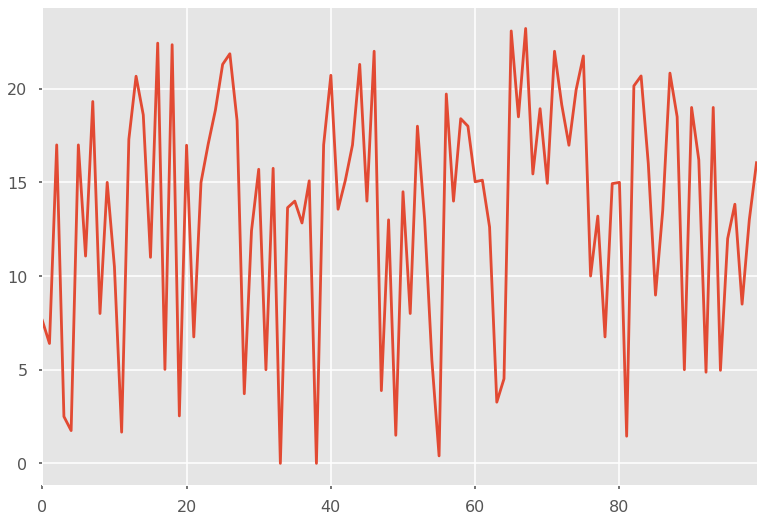

In [57]:
data.publish_hour[0:100].plot()

Na wykresie widzimy regularne skoki. Spowodowane sƒÖ przej≈õciem z godziny ~23 na godzinƒô ~0.  
By rozwiƒÖzaƒá ten problem ka≈ºda zmienna cykliczna _x_ przedstawiona zostanie za pomocƒÖ dw√≥ch zmiennych pomocniczych:
 * $x_{sin} = sin(\frac{2\pi x}{max(x)})$
 * $x_{cos} = cos(\frac{2\pi x}{max(x)})$

#### Godzina

Text(0.5, 1.0, 'Hour in cyclical coordinates')

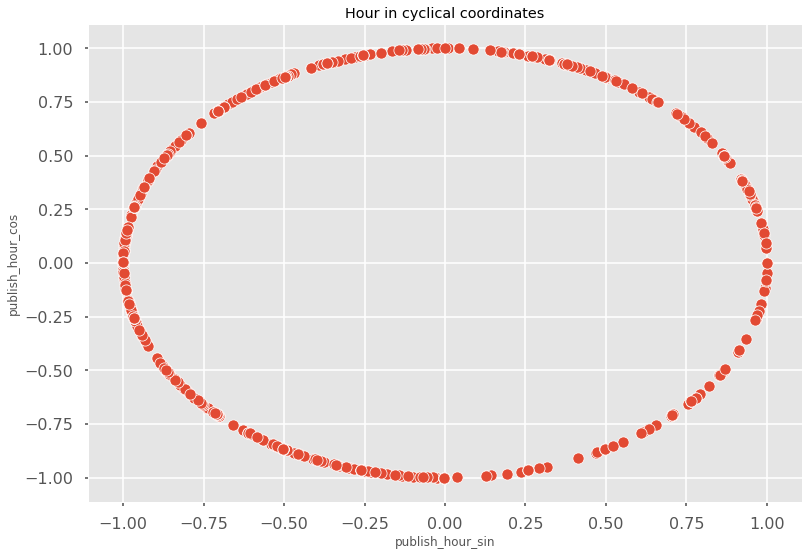

In [58]:
inner_term = 2*np.pi*data.publish_hour/np.max(data.publish_hour)
data["publish_hour_sin"] = np.sin(inner_term)
data["publish_hour_cos"] = np.cos(inner_term)
sns.scatterplot(x='publish_hour_sin', y='publish_hour_cos', data=data[::100]).set_title("Hour in cyclical coordinates")

Powy≈ºszy wykres ukazuje, i≈º uda≈Ço nam siƒô odtworzyƒá cykliczny charakter atrybutu.

#### Dzie≈Ñ tygodnia

Text(0.5, 1.0, 'Publication day of week in cyclical coordinates')

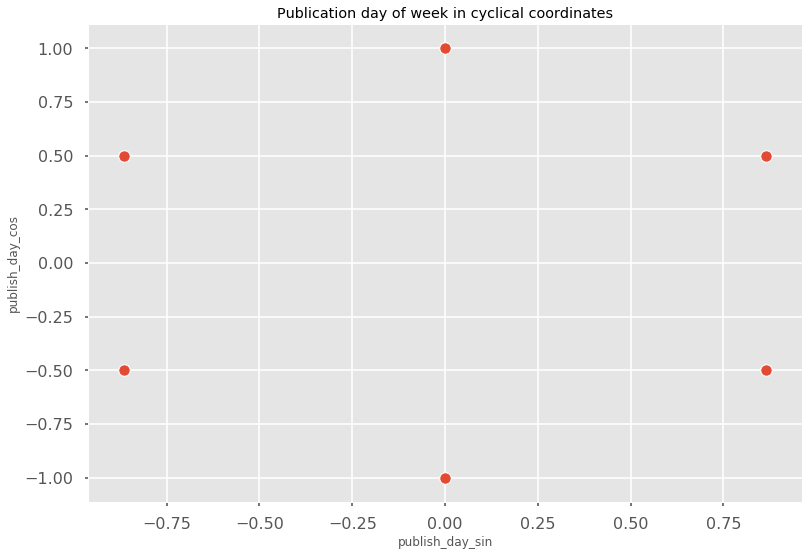

In [59]:
inner_term = 2*np.pi*data.publish_day/np.max(data.publish_day)
data["publish_day_sin"] = np.sin(inner_term)
data["publish_day_cos"] = np.cos(inner_term)
sns.scatterplot(x='publish_day_sin', y='publish_day_cos', data=data).set_title("Publication day of week in cyclical coordinates")

#### Dzie≈Ñ miesiƒÖca

Text(0.5, 1.0, 'Publication month in cyclical coordinates')

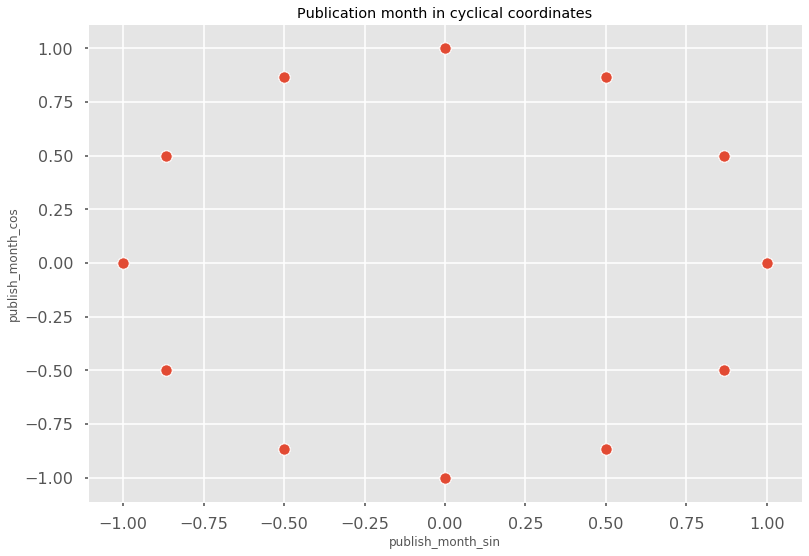

In [60]:
inner_term = 2*np.pi*data.publish_month/np.max(data.publish_month)
data["publish_month_sin"] = np.sin(inner_term)
data["publish_month_cos"] = np.cos(inner_term)
sns.scatterplot(x='publish_month_sin', y='publish_month_cos', data=data).set_title("Publication month in cyclical coordinates")

Uwtorzone atrybuty (dla ka≈ºdego sk≈Çadowa `_sin` i `_cos`):
 * `publish_hour`
 * `publish_day`
 * `publish_month`